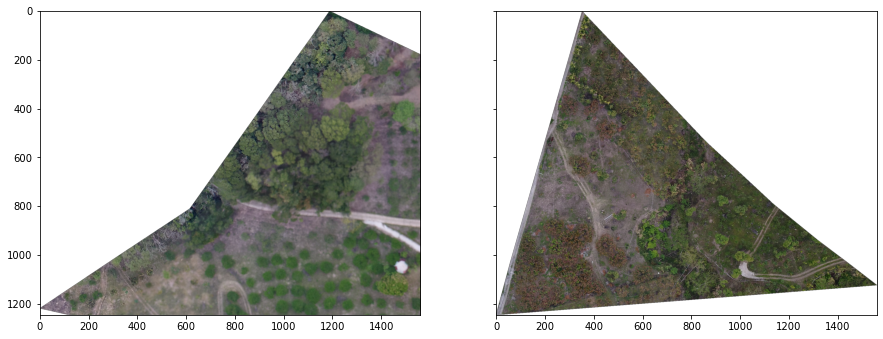

In [3]:
#方法一 Kmeans
#tif檔載入 => src
#轉換成一般RGB排列方式  => reshape
import rasterio
from rasterio.plot import reshape_as_raster, reshape_as_image, show, show_hist  #把1個1個pixel的RGB IR 獨立取出來轉成圖
from sklearn.cluster import KMeans
from sklearn import metrics
import rasterio.features
import rasterio.warp

import matplotlib.pyplot as plt
import numpy as np


src_p=[]
src_m=[]

# 全部的圖存入array
for i in range(4):  #每組有4張
    src_p.append(rasterio.open("C:/Users/2835j/Documents/KH_Image/截圖資料/截梅"+str(i+1)+".tif"))
    src_m.append(rasterio.open("C:/Users/2835j/Documents/KH_Image/截圖資料/截芒"+str(i+1)+".tif"))
img_p=[]
img_m=[]
reshape_p=[]
reshape_m=[]
for i in range(len(src_p)):
    img_p.append(src_p[i].read())
    img_m.append(src_m[i].read())
    reshape_p.append(reshape_as_image(img_p[i]))
    reshape_m.append(reshape_as_image(img_m[i]))
    
#用matplotlib畫RGB需要reshape,若只畫單個band就不用reshape
#確認有沒有載入

fig, axs = plt.subplots(1,2,figsize=(15,8),sharex=True, sharey=True)  #畫子圖 (rwo column, size)
axs[0].imshow(reshape_p[1])
axs[1].imshow(reshape_m[1])



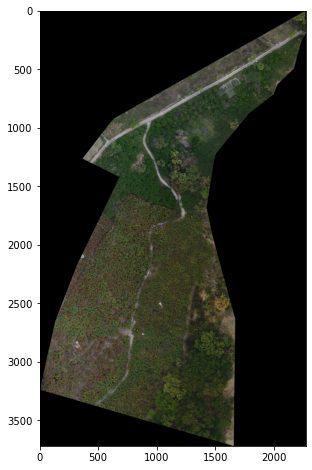

In [6]:
#加強顏色
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):  #shape[2]=>band
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors
stretched_p=[]
stretched_m=[]
for i in range(len(reshape_p)):
    stretched_p.append(color_stretch(reshape_p[i], [0,1,2]))
    stretched_m.append(color_stretch(reshape_m[i], [0,1,2]))
#確認有沒有成功加強顏色
ig, axs = plt.subplots(1,1,figsize=(15,8),sharex=True, sharey=True)  #畫子圖 (rwo column, size)
axs.imshow(stretched_p[0])

In [7]:
k = 5 # num of clusters 放入kmeans要一維矩陣
kmeans_predictions_p=[]
kmeans_predictions_m=[]
for i in range(4):
    kmeans_predictions_p.append(KMeans(n_clusters=k, random_state=0).fit(reshape_p[i].reshape(-1, 4))) #-1等於沒有，4 => 一個矩陣4個值
    kmeans_predictions_m.append(KMeans(n_clusters=k, random_state=0).fit(reshape_m[i].reshape(-1, 4)))
labels_p = []
labels_m = []
X_cluster_p=[]
X_cluster_m=[]
for i in range(len(kmeans_predictions_p)):
    labels_p.append(kmeans_predictions_p[i].labels_)
    labels_m.append(kmeans_predictions_m[i].labels_)
    
    X_cluster_p.append(np.reshape(labels_p[i], (src_p[i].meta["height"],src_p[i].meta["width"])))
    X_cluster_m.append(np.reshape(labels_m[i], (src_m[i].meta["height"],src_m[i].meta["width"])))

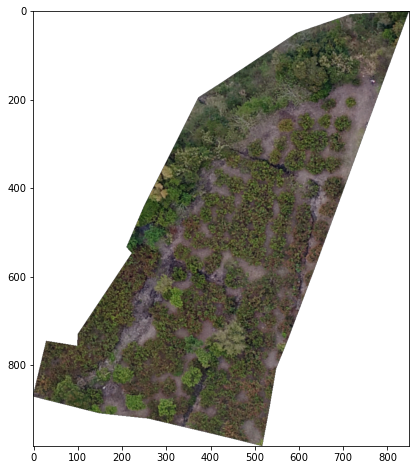

In [8]:
#選一張圖 num = 
#取得各群pixel並對應原圖 (有5群)
num = 3
h = src_m[num].meta["height"]  #src_m 為芒果
w = src_m[num].meta["width"]
X = X_cluster_m[num]
R = reshape_m[num]
Affine = src_m[num].transform  #把pixel位置轉座標需要用到

#每群個別pixel的RGB
zero=[]
one=[]
two=[]
three=[]
four=[]
#每群的pixel位置
zero_pixel=[]
one_pixel=[]
two_pixel=[]
three_pixel=[]
four_pixel=[]
count_h=1
for i in range(h):
    count = 1
    #print("*****"+str(count_h))
    for j in range(w):
        #print(count)
        if X[i][j] == 0:
            zero.append(R[i][j])
            zero_pixel.append([i,j])
            
            
        elif X[i][j] == 1:
            one.append(R[i][j])
            one_pixel.append([i,j])
        elif X[i][j] == 2:
            two.append(R[i][j])
            two_pixel.append([i,j])
            
        elif X[i][j] == 3:
            three.append(R[i][j])
            three_pixel.append([i,j])
            
            
        elif X[i][j] == 4:
            four.append(R[i][j])
            four_pixel.append([i,j])
            #將four這群的原圖pixel變色
            #R[i][j][0] = 255
            #R[i][j][1] = 255
            #R[i][j][2] = 0
            
            
        count+=1
    count_h+=1
   
fig, axs = plt.subplots(1,1,figsize=(15,8),sharex=True, sharey=True)    
axs.imshow(R)


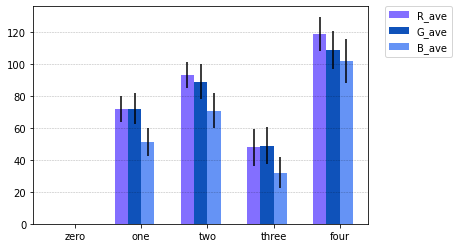

In [9]:
#畫長條圖   
import statistics

class Calcul:
    def __init__(self, cluster):
        r=[]
        g=[]
        b=[]
        for rgb in cluster:
            r.append(rgb[0])
            g.append(rgb[1])
            b.append(rgb[2])
        self.r_ave = statistics.mean(r)
        self.g_ave = statistics.mean(g)
        self.b_ave = statistics.mean(b)
        r_np = np.array(r)
        g_np = np.array(g)
        b_np = np.array(b)
        self.r_std = np.std(r_np, ddof=1)  #ddof=1 樣本標準差
        self.g_std = np.std(g_np, ddof=1)
        self.b_std = np.std(b_np, ddof=1)
zero_cluster = Calcul(zero)
one_cluster = Calcul(one)
two_cluster = Calcul(two)
three_cluster = Calcul(three)
four_cluster = Calcul(four)


X_name = ["zero", "one", "two", "three", "four"]  #五群
ave_zero = [zero_cluster.r_ave, zero_cluster.g_ave,zero_cluster.b_ave]
ave_one = [one_cluster.r_ave, one_cluster.g_ave,one_cluster.b_ave]
ave_two = [two_cluster.r_ave, two_cluster.g_ave,two_cluster.b_ave]
ave_three = [three_cluster.r_ave, three_cluster.g_ave,three_cluster.b_ave]
ave_four = [four_cluster.r_ave, four_cluster.g_ave,four_cluster.b_ave]
std_zero = [zero_cluster.r_std, zero_cluster.g_std, zero_cluster.b_std]
std_one = [one_cluster.r_std, one_cluster.g_std, one_cluster.b_std]
std_two = [two_cluster.r_std, two_cluster.g_std, two_cluster.b_std]
std_three = [three_cluster.r_std, three_cluster.g_std, three_cluster.b_std]
std_four = [four_cluster.r_std,four_cluster.g_std,four_cluster.b_std]
data = np.array([ave_zero, ave_one, ave_two, ave_three, ave_four])
data_std = np.array([std_zero, std_one, std_two, std_three, std_four])
length = len(data)
fig, ax = plt.subplots()
width = 0.2 # width of bar
x = np.arange(length)

ax.bar(x, data[:,0], width, color='#836FFF', label='R_ave', yerr=data_std[:,0])
ax.bar(x + width, data[:,1], width, color='#0F52BA', label='G_ave', yerr=data_std[:,1])
ax.bar(x + (2 * width), data[:,2], width, color='#6593F5', label='B_ave', yerr=data_std[:,2])
#ax.bar(x + (3 * width), data[:,3], width, color='#FF44AA', label='R_std')
#ax.bar(x + (4 * width), data[:,4], width, color='#FF0000', label='G_std')
#ax.bar(x + (5 * width), data[:,5], width, color='#AA0000', label='B_std')
ax.set_xticks(x + width + width/2)
ax.set_xticklabels(X_name)
#plt.bar(X_name - 0.2, ave_one, label = 'class_one',align = "edge",width=0.25)
#plt.bar(X_name2, ave_two, label = 'class_two',align = "edge",width=0.25)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
ax.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
plt.show()

c:\users\2835j\anaconda3\envs\uav_image\lib\site-packages\IPython\core\interactiveshell.py:3417: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\users\2835j\anaconda3\envs\uav_image\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


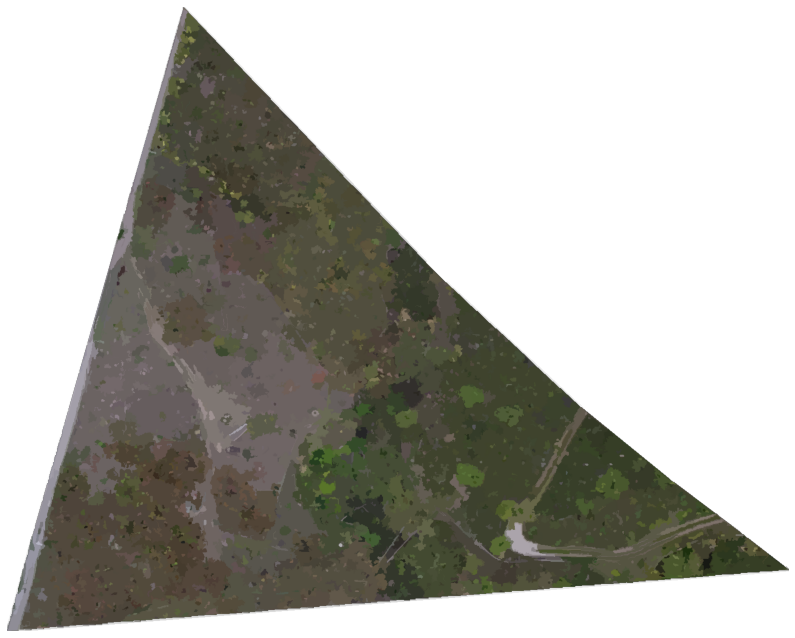

In [41]:
#方法二  scikit-image
#改reshape_m
from skimage import io
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
import skimage.measure as measure

def image_show(image, nrows=1, ncols=1, cmap="gray"):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,14))
    ax.imshow(image, cmap="gray")
    ax.axis("off")
    return fig, ax
image = reshape_m[1]            
image_felzenszwalb = seg.felzenszwalb(image, scale=90, sigma=1) 

np.unique(image_felzenszwalb).size
image_felzenszwalb_colored = color.label2rgb(image_felzenszwalb, image, kind="avg")
image_show(image_felzenszwalb_colored)
region_t = measure.regionprops(image_felzenszwalb)

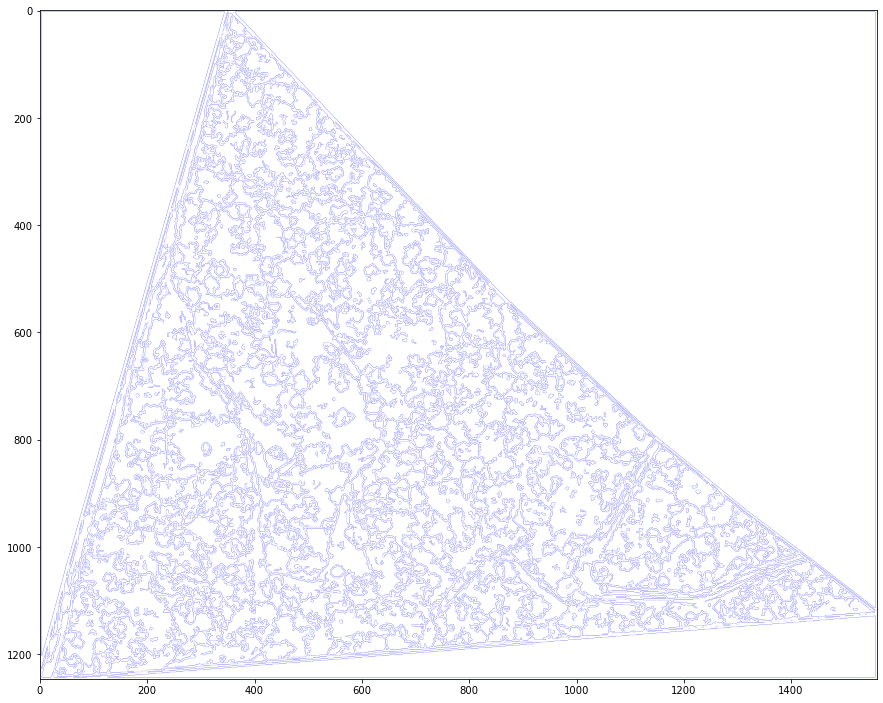

In [42]:
#訓練資料
#skimage產生shp, 利用 section一個一個抓出來畫contour   
#gdf.to_file記得改檔名  
#Affine記得改
import cv2
import geopandas as gpd
import pandas as pd
import skimage.morphology as sm
from shapely.geometry import Polygon
Affine = src_m[1].transform  #仿射轉換參數
list_polygon=[]
list_section_coords=[] 
list_key=[]

key = 1
def contour_polygon(contours, section,key):
    contour = map(np.squeeze, contours)
    list_contour=[]  #
    np_contour = np.array(list_contour)
    list2=[] #
    temp_list_polygon=[] #
    
    for i in list(contour):   #list(contour)的大lsit為lsit，但裡面的element為np.array，因此要把每個轉換成list
        list_contour.append(i.tolist())
    #找出小於兩個點的polygon
    for i in list_contour:
        if len(i) <= 2:
            list2.append(i)
    #刪掉小於兩個點的
    for i in list2:
        list_contour.remove(i)
    
    for poly in list_contour:
        for point in poly:
            Affine_tuple = Affine*(point[0],point[1])   #像座標轉換成地面座標    
            point[0] = Affine_tuple[0]
            point[1] = Affine_tuple[1]
        temp = Polygon(poly)
        if 1 < temp.area < 1000:
            list_polygon.append(temp)
            list_section_coords.append(section)
            list_key.append(key)

count = 0
skimage = np.zeros(image.shape, np.uint8)
skimage = np.where(skimage==0, np.array([255,255,255,255],dtype=np.uint8),skimage)
for section in region_t:
    if section["area"] < 150:
        continue
    for rowcol in section["coords"]:
        skimage[rowcol[0], rowcol[1]] = np.array([0,0,0,255],dtype=np.uint8)
    b,g,r,ir = cv2.split(skimage)
    merged = cv2.merge((b,g,r))
    gray = cv2.cvtColor(merged, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(gray,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) 
    contour_polygon(contours,section["coords"],key)
    cv2.drawContours(skimage,contours,-1,(0,0,255),3)
    for rowcol in section["coords"]:
        skimage[rowcol[0], rowcol[1]] = np.array([255,255,255,255],dtype=np.uint8)
    key+=1
    
fig, axs = plt.subplots(1,1,figsize=(15,100),sharex=True, sharey=True)
axs.imshow(skimage)

section_dic={"key": list_key, "section_coords":list_section_coords}
key_dic = {"key": list_key}
df_section_coords_t = pd.DataFrame(section_dic)  #等等標記完的shp要回來對應section_coords
df_key = pd.DataFrame(key_dic)
gdf = gpd.GeoDataFrame(df_key,geometry=list_polygon,crs="EPSG:3826")
#用m1_test測試是否能夠產生shp(程式碼是否對)，因為m1之前已產生且標記完了，不能覆蓋掉
gdf.to_file("C:/Users/2835j/Documents/uavagri_sanbox/scikit_shp/m1_test.shp",driver='ESRI Shapefile')  

In [ ]:
#至QGIS匯入SHP,並新增一欄type紀錄每個polygon對應的特徵，例如芒果、樹、土地

In [22]:
#訓練資料
#取得每個poloygon裡面的RGB平均值和DSM的數值  改read_file的檔名
from itertools import compress 
gdf_shp = gpd.read_file("C:/Users/2835j/Documents/uavagri_sanbox/scikit_shp/m1.shp", encoding="utf-8")   #把標記好的shp讀進來
gdf_merge = df_section_coords_t.merge(gdf_shp, on="key")  #和section_coords結合，標記的特徵才能對應座標
ave_RGB_t=[]
gdf_new_merge_t= gdf_merge[gdf_merge.type != "none"]

try:
    detect_type = list(gdf_new_merge_t["type"])
except:
    pass

def calculRGB(pixel_list):
    red=0 
    green=0 
    blue=0 
    NI=0
    for i in pixel_list:
        red0, green0, blue0,NI0 = image[i[0]][i[1]]
        red = red+red0
        green = green+ green0
        blue = blue+ blue0
        NI = NI + NI0
    red_ave = red/len(pixel_list)
    green_ave = green/len(pixel_list)
    blue_ave = blue/len(pixel_list)
    NI_ave = NI/len(pixel_list)
    return [red_ave, green_ave, blue_ave, NI_ave]

for single_region in gdf_new_merge_t["section_coords"]:
    value = calculRGB(single_region)
    ave_RGB_t.append(value)

In [23]:
#SVM 利用訓練資料訓練
from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris=datasets.load_iris()
X=iris.data
y=iris.target
RGB_train, RGB_test, type_train, type_test = train_test_split(ave_RGB_t, detect_type, test_size=0.2)
clf=svm.SVC(kernel='linear',C=5,gamma='auto')  #參數調整
clf.fit(RGB_train,type_train)
clf.predict(ave_RGB_t)
print(clf.score(RGB_test,type_test))

0.7880794701986755


c:\users\2835j\anaconda3\envs\uav_image\lib\site-packages\IPython\core\interactiveshell.py:3417: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\users\2835j\anaconda3\envs\uav_image\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  del sys.path[0]


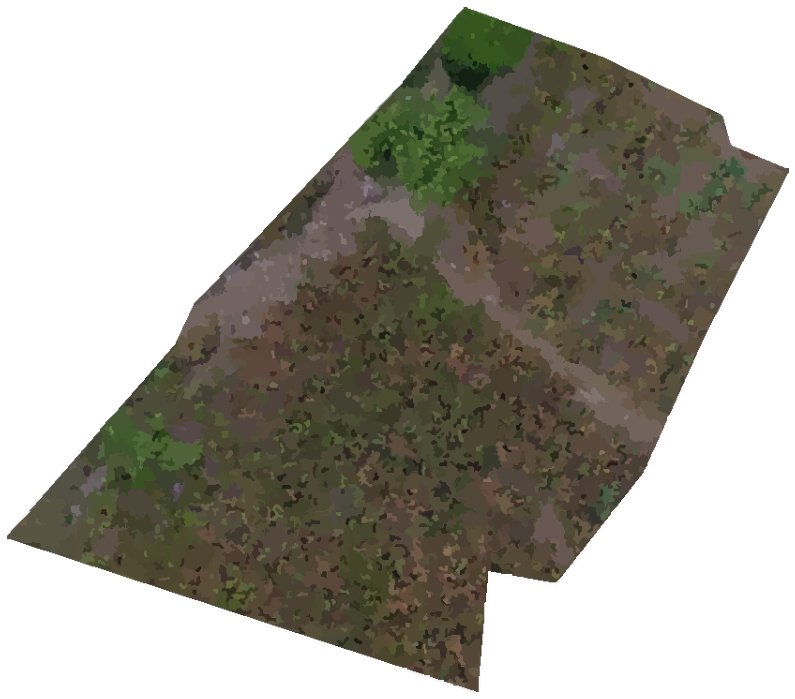

In [31]:
#預測資料
#scikit-image   改image

def image_show(image, nrows=1, ncols=1, cmap="gray"):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,14))
    ax.imshow(image, cmap="gray")
    ax.axis("off")
    return fig, ax
image = reshape_m[2]            
image_felzenszwalb = seg.felzenszwalb(image, scale=46, sigma=1) 

np.unique(image_felzenszwalb).size
image_felzenszwalb_colored = color.label2rgb(image_felzenszwalb, image, kind="avg")
image_show(image_felzenszwalb_colored)
region_p = measure.regionprops(image_felzenszwalb)

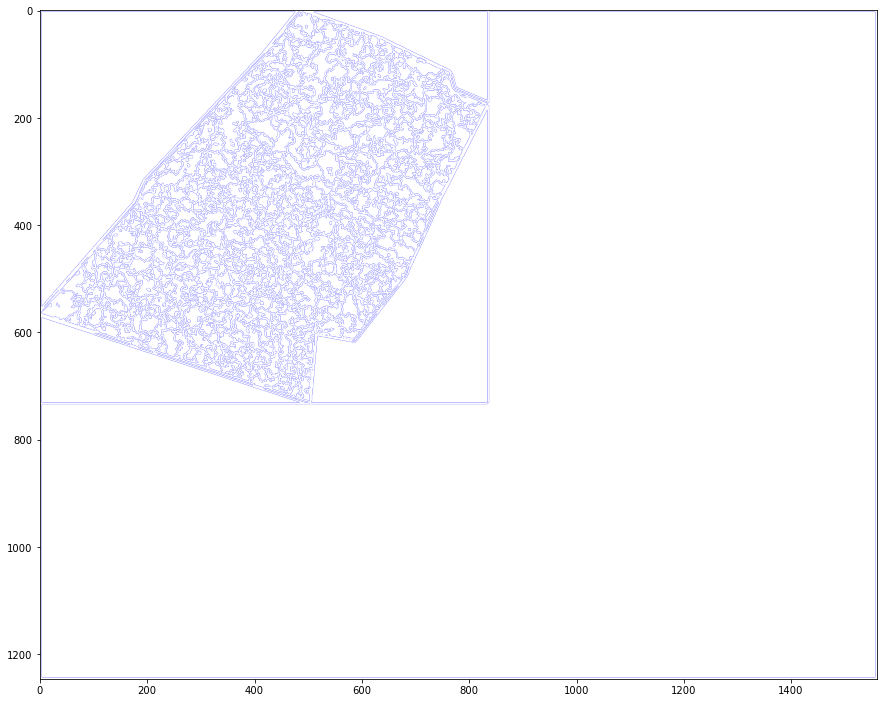

In [43]:
#預測資料
#skimage產生shp, 利用 section一個一個抓出來畫contour   
#gdf.to_file記得改檔名  
#Affine記得改

Affine = src_m[2].transform
list_polygon=[]#
list_section_coords=[] #
list_key=[]
key = 1

def contour_polygon(contours, section,key):
    contour = map(np.squeeze, contours)
    list_contour=[]  #
    np_contour = np.array(list_contour)
    list2=[] #
    temp_list_polygon=[] #
    
    for i in list(contour):   #list(contour)的大lsit為lsit，但裡面的element為np.array，因此要把每個轉換成list
        list_contour.append(i.tolist())
    #找出小於兩個點的polygon
    for i in list_contour:
        if len(i) <= 2:
            list2.append(i)
    #刪掉小於兩個點的
    for i in list2:
        list_contour.remove(i)
    
    for poly in list_contour:
        for point in poly:
            Affine_tuple = Affine*(point[0],point[1])   #像座標轉換成地面座標    
            point[0] = Affine_tuple[0]
            point[1] = Affine_tuple[1]
        temp = Polygon(poly)
        if 1 < temp.area < 1000:
            list_polygon.append(temp)
            list_section_coords.append(section)
            list_key.append(key)
count = 0
skimage = np.zeros(image.shape, np.uint8)
skimage = np.where(skimage==0, np.array([255,255,255,255],dtype=np.uint8),skimage)
for section in region_p:
    if section["area"] < 150:
        continue
    #color = [random.randint(0, 255), random.randint(0, 255),random.randint(0, 255),255]
    for rowcol in section["coords"]:
        skimage[rowcol[0], rowcol[1]] = np.array([0,0,0,255],dtype=np.uint8)
    b,g,r,ir = cv2.split(skimage)
    merged = cv2.merge((b,g,r))
    gray = cv2.cvtColor(merged, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(gray,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) 
    contour_polygon(contours,section["coords"],key)
    cv2.drawContours(skimage,contours,-1,(0,0,255),3)
    for rowcol in section["coords"]:
        skimage[rowcol[0], rowcol[1]] = np.array([255,255,255,255],dtype=np.uint8)
    key+=1
    
fig, axs = plt.subplots(1,1,figsize=(15,100),sharex=True, sharey=True)
axs.imshow(skimage)

section_dic={"key": list_key, "section_coords":list_section_coords}
key_dic = {"key": list_key}
df_section_coords_p = pd.DataFrame(section_dic)
df_key = pd.DataFrame(key_dic)
gdf = gpd.GeoDataFrame(df_key,geometry=list_polygon,crs="EPSG:3826")
gdf.to_file("C:/Users/2835j/Documents/uavagri_sanbox/scikit_shp/m3.shp",driver='ESRI Shapefile')

In [44]:
#預測資料
#取得每個poloygon裡面的RGB平均值和DSM的數值  改read_file的檔名
from itertools import compress 
gdf_shp_p = gpd.read_file("C:/Users/2835j/Documents/uavagri_sanbox/scikit_shp/m3.shp", encoding="utf-8")
#gdf_merge = gdf_region.merge(gdf_shp, on="FID")
gdf_merge_p = df_section_coords_p.merge(gdf_shp_p, on="key")
ave_RGB_p=[]


try:
    detect_type_p = list(gdf_merge_p["type"])
except:
    pass

def calculRGB(pixel_list):
    red=0 
    green=0 
    blue=0 
    NI=0
    for i in pixel_list:
        red0, green0, blue0,NI0 = image[i[0]][i[1]]
        red = red+red0
        green = green+ green0
        blue = blue+ blue0
        NI = NI + NI0
    red_ave = red/len(pixel_list)
    green_ave = green/len(pixel_list)
    blue_ave = blue/len(pixel_list)
    NI_ave = NI/len(pixel_list)
    return [red_ave, green_ave, blue_ave, NI_ave]

for single_region in gdf_merge_p["section_coords"]:
    value = calculRGB(single_region)
    ave_RGB_p.append(value)

In [45]:
#SVM預測,產生shp
SVM_predict_type = clf.predict(ave_RGB_p)
gdf_merge_p["type"] = list(SVM_predict_type)
del gdf_merge_p["section_coords"]
gdf_p = gpd.GeoDataFrame(gdf_merge_p,geometry=gdf_merge_p["geometry"],crs="EPSG:3826")
gdf_p.to_file("C:/Users/2835j/Documents/uavagri_sanbox/scikit_shp/m3_predict.shp",driver='ESRI Shapefile')
print(SVM_predict_type)

['mango' 'mango' 'mango' 'mango' 'mango' 'mango' 'mango' 'mango' 'mango'
 'mango' 'mango' 'mango' 'mango' 'mango' 'mango' 'mango' 'mango' 'mango'
 'mango' 'mango' 'mango' 'mango' 'mango' 'mango' 'mango' 'mango' 'grass'
 'mango' 'mango' 'mango' 'mango' 'mango' 'mango' 'mango' 'grass' 'mango'
 'mango' 'mango' 'mango' 'mango' 'mango' 'ground' 'mango' 'tree' 'grass'
 'mango' 'mango' 'mango' 'ground' 'mango' 'ground' 'mango' 'mango' 'mango'
 'ground' 'mango' 'mango' 'mango' 'mango' 'tree' 'mango' 'mango' 'mango'
 'mango' 'mango' 'ground' 'ground' 'mango' 'mango' 'ground' 'mango'
 'mango' 'mango' 'mango' 'ground' 'tree' 'mango' 'mango' 'mango' 'mango'
 'mango' 'mango' 'tree' 'ground' 'mango' 'mango' 'mango' 'ground' 'mango'
 'mango' 'mango' 'mango' 'tree' 'mango' 'mango' 'ground' 'ground' 'ground'
 'ground' 'mango' 'mango' 'mango' 'tree' 'mango' 'grass' 'mango' 'mango'
 'mango' 'ground' 'mango' 'mango' 'tree' 'ground' 'tree' 'ground' 'mango'
 'tree' 'ground' 'mango' 'mango' 'tree' 'mango' 'g